# HABSlib 101

In this first notebook, we will move our first steps into the HABSlib client library for the HABS BrainOS API.    
This library allows you to record, store safely, and analyze EEG data, using the HABS BrainOS platform.

In this first crash course, we will look at installation, handshake, using the HABS generator of dummy EEG signals, and perform several analyses on them.

## Installation
First, we install the necessary libraries.    
- HABSlib
- nest_asyncio (to allow HABSlib to run in a Jupyter notebook, which has already a async loop in each cell)

In [1]:
pip install HABSlib

  Obtaining dependency information for HABSlib from https://files.pythonhosted.org/packages/c0/a8/6019c6cbaa438b073e8b6d887d0115cc4deca425148bc6be458667e8ed63/HABSlib-0.1.27-py3-none-any.whl.metadata
  Obtaining dependency information for asyncio==3.4.3 from https://files.pythonhosted.org/packages/22/74/07679c5b9f98a7cb0fc147b1ef1cc1853bc07a4eb9cb5731e24732c5f773/asyncio-3.4.3-py3-none-any.whl.metadata
  Obtaining dependency information for brainflow==5.12.1 from https://files.pythonhosted.org/packages/c8/2a/503d9d68da49a4afe50bf5674ad559f98284515ef273ece9ed43df4d74e7/brainflow-5.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for scipy==1.13.0 from https://files.pythonhosted.org/packages/b9/9d/39dbcf49a793157f9d4f5b8961855677eb4dbb4b82700dcee7042ad2310c/scipy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
  Obtaining dependency information for urllib3==2.2.1 fr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.7/28.7 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 18.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.9/339.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for pytest-dependency: filename=pytest_dependency-0.6.0-py3-none-any.whl size=8931 sha256=b885466d1d024c0e01c1bd940076b1b9080c5af590b128dda5ff896d9a5d1fd2
  Stored in directory: /home/jovyan/.cache/pip/wheels/41/e1/20/574482a4d7b632f7d322eb266a818dc7607f2d969b42b90076
Successfully built pytest-dependency
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.6
    Uninstall

In [2]:
pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [4]:
hb.handshake(base_url="http://74.249.61.11", user_id='666c0158fcbfd9a830399121')


     ---------------------------------------------------------------------------------- 
     HHHHHH       HHHHHH        AAAAAAAAA        BBBBBBBBBBBBBB          SSSSSSSSSSS    
     HHHHHH       HHHHHH       AAAAAAAAAA        BBBBBBBBBBBBBBBBB    SSSSSSSSSSSSSSSS  
     HHHHHH       HHHHHH       AAAAAAAAAAA       BBBBBBBBBBBBBBBBBB   SSSSSS    SSSSSSS 
     HHHHHH       HHHHHH      AAAAAA AAAAAA                  BBBBBB   SSSSS             
     HHHHHHHHHHHHHHHHHHH     AAAAAA  AAAAAAA     BBBBBBBBBBBBBBBB     SSSSSSSSSSSSSS    
     HHHHHHHHHHHHHHHHHHH     AAAAAA   AAAAAA     BBBBBBBBBBBBBBBBB       SSSSSSSSSSSSSS 
     HHHHHH       HHHHHH    AAAAAA     AAAAAA    BBBBB       BBBBBB              SSSSSS 
     HHHHHH       HHHHHH   AAAAAA       AAAAAA   BBBBBBBBBBBBBBBBBB  SSSSSSS    SSSSSSS 
     HHHHHH       HHHHHH  AAAAAAA       AAAAAA   BBBBBBBBBBBBBBBBBB   SSSSSSSSSSSSSSSS  
     HHHHHH       HHHHHH  AAAAAA         AAAAAA  BBBBBBBBBBBBBB         SSSSSSSSSSSS    
     ---------------

True

## Get user data
You can query the user data stored on the server

In [5]:
user_data = hb.get_user_by_id(user_id='666c0158fcbfd9a830399121')
print(user_data)

User found.
{'_id': {'$oid': '666c0158fcbfd9a830399121'}, 'user_data': {'first_name': 'Domenico', 'last_name': 'Guarino', 'role': 'Admin', 'group': 'HABS', 'email': 'domenico@habs.ai', 'age': 50.0, 'weight': 89.0, 'gender': 'M'}}


## Acquire data and send
For this tutorial, we use the synthetic board included in the HABSlib, which allows you to define:
- number of EEG channels ('eeg_channels')
- sampling frequency of the channels ('sampling_rate')
- level of noise ('noise' between 0, no noise, and 1)
- probability of observing a generic artifact ('artifacts')
- type of envelope modulation of the EEG (currently 'sinusoidal', at 0.1Hz, or 'random', with mean=0 var=1)
- amplitude in each of the frequency bands ('delta_amp', 'theta_amp', ...)
- some 'preset' amplitude contents for different states ('focus', 'alert', 'relaxed', 'drowsy')
- the presets can be put in a sequence to vary the signal over time
- correlation can be introduced between nearby channels ('correlation_strength')

As you can see, there are quite a number of options to play with even without an actual EEG device ;)

In [6]:
from datetime import datetime

session_id = hb.acquire_send_raw(
    user_id='666c0158fcbfd9a830399121', 
    date=datetime.today().strftime('%Y-%m-%d'), 
    board="SYNTHETIC", 
    extra={
        "eeg_channels": 16,
        "sampling_rate": 250,
        "noise": 1,
        "artifacts": 0.001,
        "modulation_type": 'random',
        "preset": 'focus', # None # 
        "sequence": None, # [("focus", 20), ("relaxed", 20)],
        "correlation_strength": 0.5
    },
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)
print("this session:", session_id)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66784ad0a2a2481204079813 

Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...
this session: 66784ad0a2a2481204079813


In [8]:
import numpy as np

results = hb.get_data_by_session(user_id='666c0158fcbfd9a830399121', session_id='66784ad0a2a2481204079813')
data = np.array(results)
print(data.shape)
print(data) 

Retrieved data successfully.
(16, 5000)
[[ 5.80122698e-01  1.20538437e+00  1.26273258e+00 ... -9.01545589e-01
  -8.29044154e-01 -1.03535201e+00]
 [ 1.88227471e+00 -1.52862017e-01  1.08605190e+00 ... -1.44002708e+00
  -2.17582983e+00  8.79931041e-02]
 [ 1.53722117e+00 -1.54500945e-02  2.35867441e+00 ... -5.53036980e-02
  -2.76689468e+00 -6.21975032e-01]
 ...
 [-3.72772519e-01 -2.62980781e-01  9.46272051e-01 ... -6.73622399e-01
  -1.03589214e+00 -2.29088061e+00]
 [-3.34648520e-01  1.08761926e+00  2.90866592e+00 ... -1.70290630e+00
  -4.92534015e-01  1.49685665e+00]
 [ 5.17467060e+02 -2.03620506e+02  3.04530268e+02 ...  1.92098216e+02
  -2.59796320e+02  6.19524930e+02]]


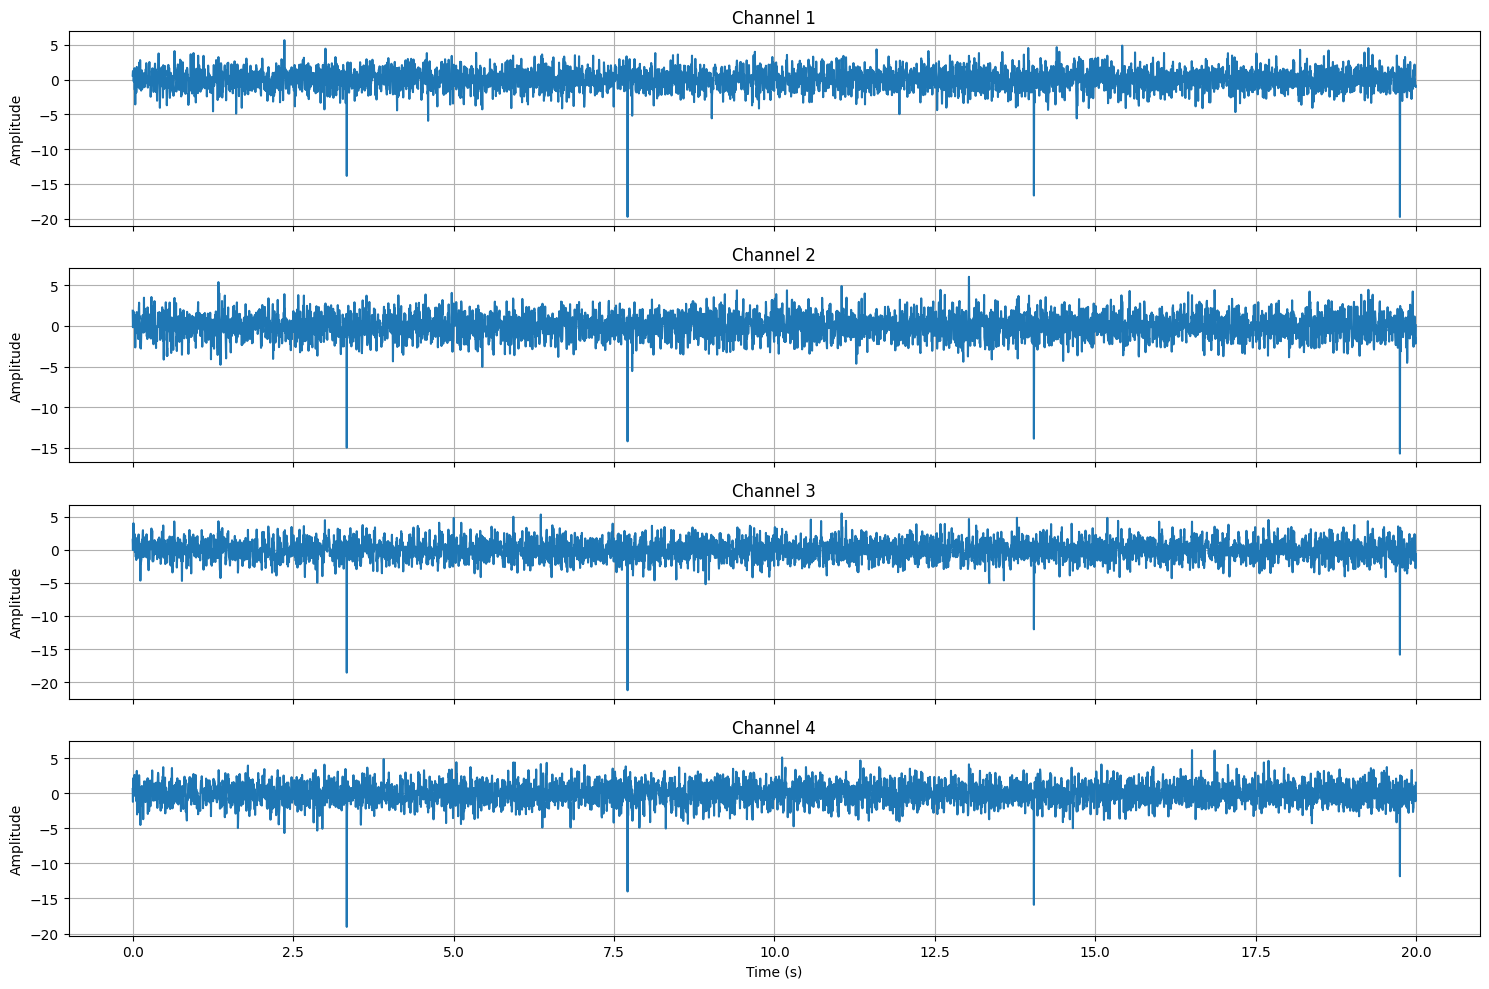

In [14]:
import matplotlib.pyplot as plt

samples_per_second = 250
num_channels=4 # how many you want to plot
    
time = np.arange(data.shape[1]) / samples_per_second
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i, ax in enumerate(axes[:num_channels]):
    ax.plot(time, data[i])
    ax.set_title(f'Channel {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

We passed 'focus' as parameter of the dummy EEG generator. This implies the following amplitude proportions:     
```   
            del  the  alp  bet  gam
'focus':   [0.1, 0.1, 0.5, 0.8, 0.4]
```
Is it what we find in the signal if we perform a PSD?

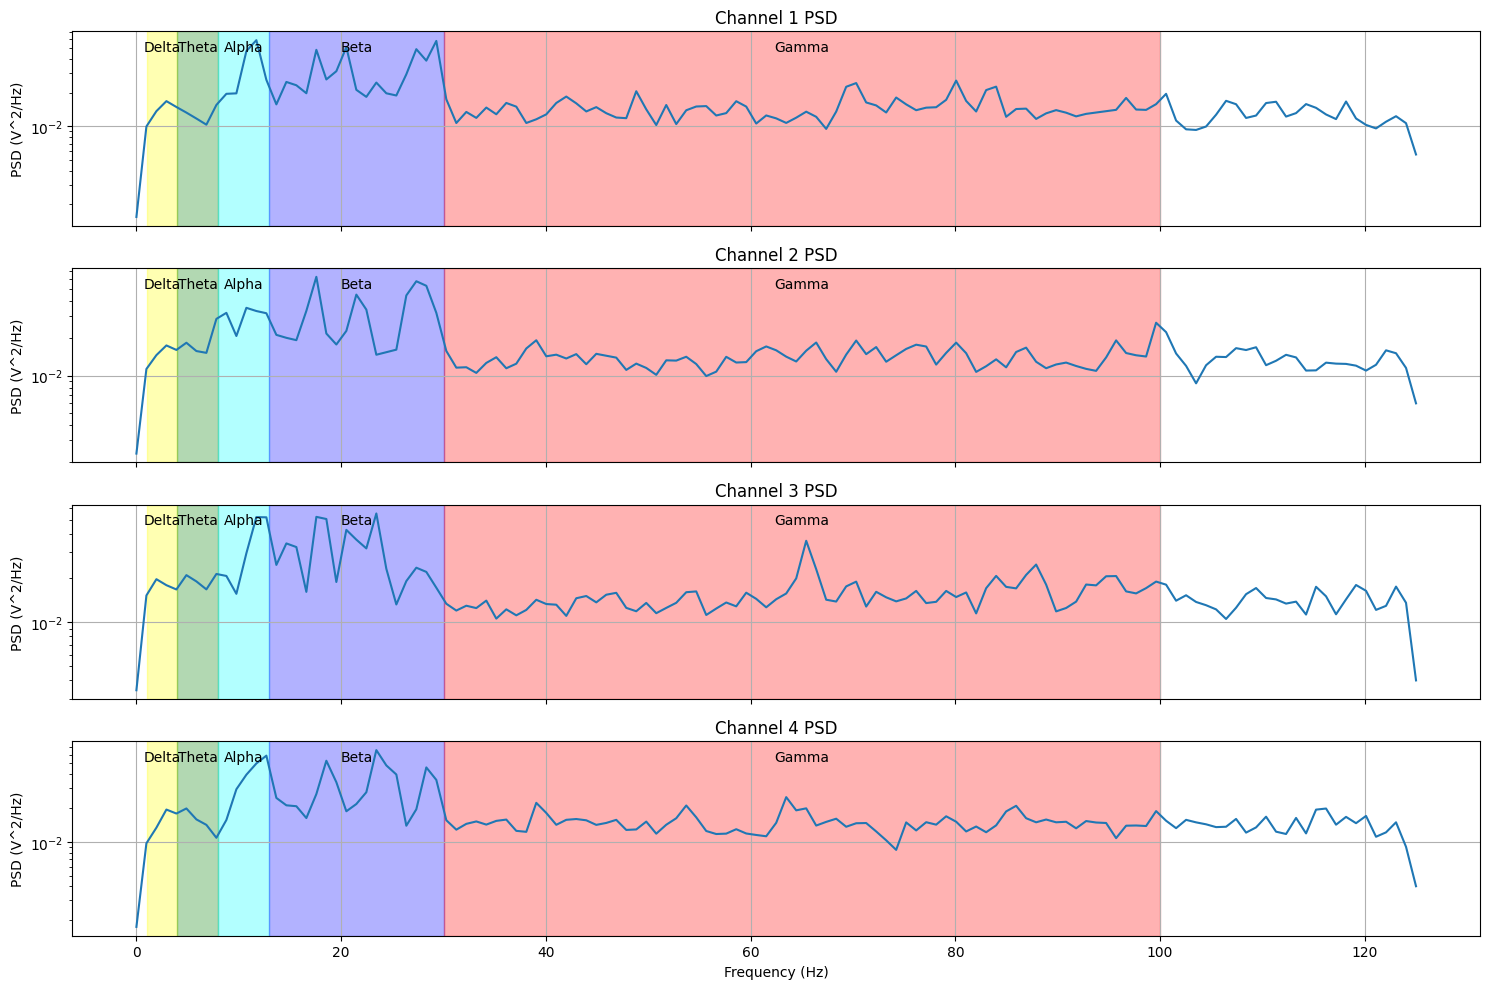

In [20]:
from scipy import signal

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(data[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

Indeed we find a relatively higher content of Alpha and Beta